# **Deep Convolutional GAN (DCGAN)**

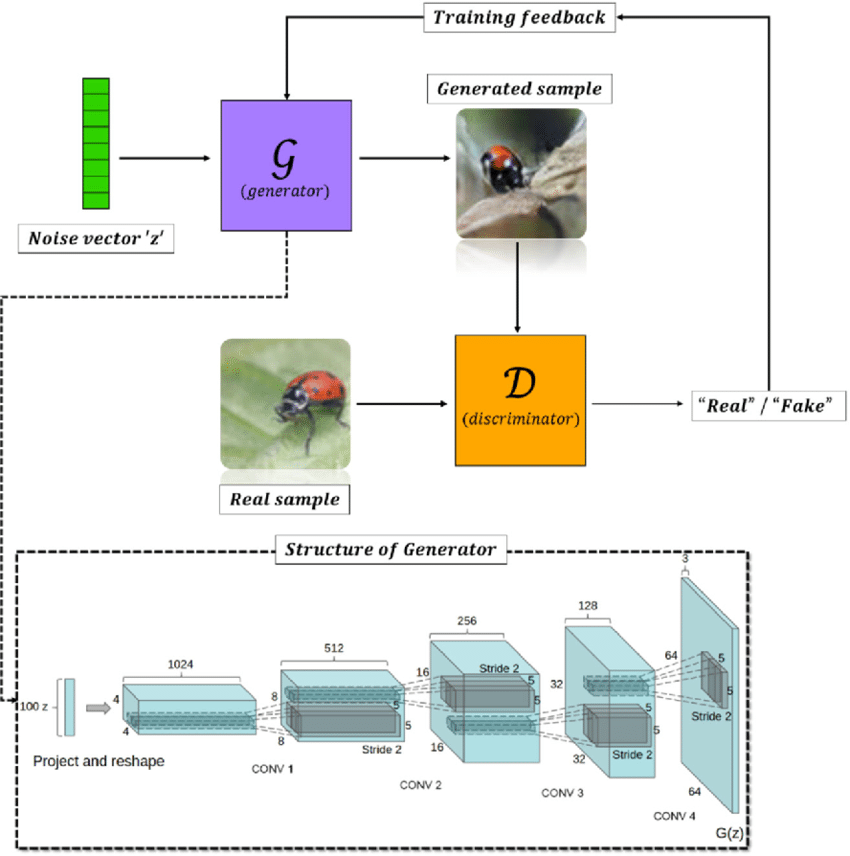

### DCGAN paper : https://arxiv.org/abs/1511.06434
### Github link : https://github.com/amanchadha/coursera-gan-specialization/blob/main/C1%20-%20Build%20Basic%20Generative%20Adversarial%20Networks/Week%202/C1_W2_Assignment.ipynb

### **Features of DCGAN:**

#### - Use convolutions without any pooling layers
#### - Use batchnorm in both the generator and the discriminator
#### - Use ReLU activation in the generator for all layers except for the output,  which uses a Tanh activation.
#### - Use LeakyReLU activation in the discriminator for all layers except for the output, which does not use an activation

In [1]:
#importing required packages
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

## Generator
#### Building a generator having 6 layers.

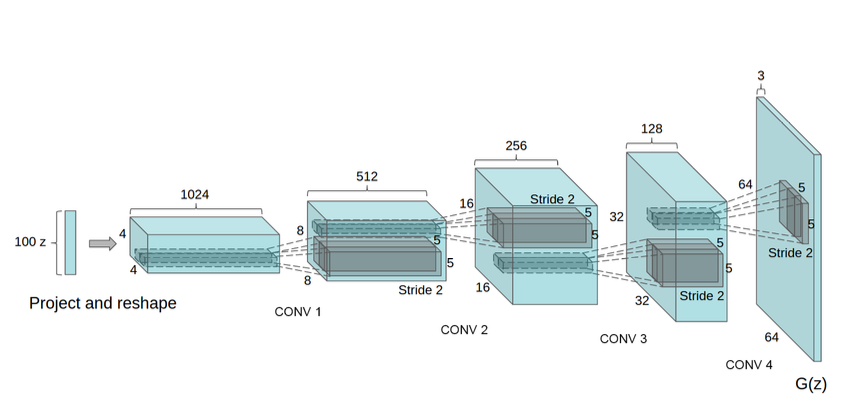

In [2]:
# Generator (for generating fake images)

class Generator(nn.Module):
  
    # z_dim : noise vector dimension
    # output_channel : tnumber of channels of the output image, it is 1 for MNIST(black and white) dataset.
    # hidden_dimension : inner dimension of the generator model

    def __init__(self, z_dimension=10, output_channel=1, hidden_dimension=64):
        super(Generator, self).__init__()

        self.z_dimension = z_dimension

        # Building the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dimension, hidden_dimension * 2),
            self.make_gen_block(hidden_dimension * 2, hidden_dimension * 4),
            self.make_gen_block(hidden_dimension * 4, hidden_dimension * 8, stride=1),
            self.make_gen_block(hidden_dimension * 8, hidden_dimension * 4, stride=1),
            self.make_gen_block(hidden_dimension * 4, hidden_dimension * 2, stride=1),
            self.make_gen_block(hidden_dimension * 2, output_channel, kernel_size=4, final_layer=True),
        )


    # building neural block
    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):

        # input_channels : number of input channel
        # output_channels : number of output channel
        # kernel_size : size of convolutional filter
        # stride : stride of the convolution
        # final_layer : boolean value, true if it is the final layer and false otherwise 

        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )

        # Final Layer
        else: 
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
            )
  
    # Function for completing a forward pass of the generator: Given a noise tensor, returns generated images.
    def forward(self, noise):
        
        # noise: a noise tensor with dimensions (n_samples, z_dimension)
        

        # a noise with width = 1, height = 1, number of channels = z_dimension, number of samples = len(noise)
        x = noise.view(len(noise), self.z_dimension, 1, 1)
        return self.gen(x)


    # Function for creating noise vectors: Given the dimensions (n_samples, z_dim) creates a tensor of that shape filled with random numbers 
    # from the normal distribution
    def get_noise(self, n_samples, device='cpu'):
    
        # n_samples: the number of samples to generate, a scalar
        # z_dimension: the dimension of the noise vector, a scalar
        # device: the device type (cpu / cuda)
    
        return torch.randn(n_samples, self.z_dimension, device=device)

## Discriminator
### Building a discriminator having 4 layers
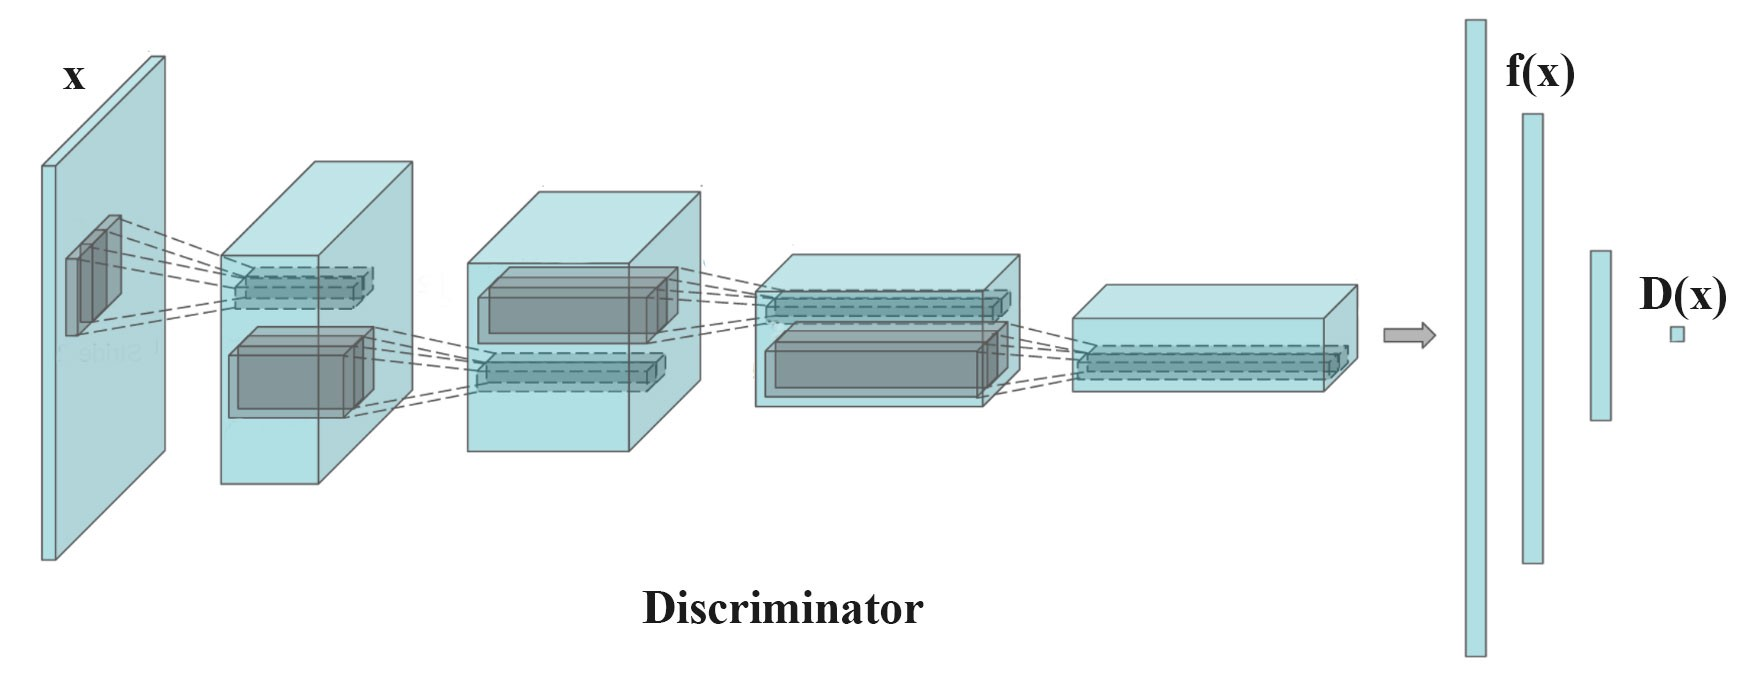

In [3]:
# Discriminator

class Discriminator(nn.Module):

    # im_chan :  number of output channel (1 channel for MNIST dataset which has balck and white image)
    # hidden_dim : number of inner channel

    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim * 2, stride=1),
            self.make_disc_block(hidden_dim * 2, hidden_dim * 4),
            self.make_disc_block(hidden_dim * 4, hidden_dim * 2),

            self.make_disc_block(hidden_dim * 2, 1, kernel_size=4, final_layer=True),
        )


    # Build the neural block
    def make_disc_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):

        # input_channels : number of input channels
        # output_channels : number of output channels
        # kernel_size : the size of each convolutional filter
        # stride : the stride of the convolution
        # final_layer : a boolean, true if it is the final layer and false otherwise 

        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )

    # Function for completing a forward pass of the discriminator: Given an image tensor, returns a 1-dimension tensor representing fake/real.
    def forward(self, image):
        # image: a flattened image tensor 
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

## Training Parameters

In [4]:
# loss function
criterion = nn.BCEWithLogitsLoss()

# dimension of the noise vector
z_dim = 64

# ow often to display/visualize the images
display_step = 1000

# number of images per forward/backward pass
batch_size = 128

# the learning rate
lr = 0.0002

#the device type 
device = 'cuda'

# the momentum term
beta_1 = 0.5 
beta_2 = 0.999

# the number of times you iterate through the entire dataset when training
n_epochs = 100

## Downloading dataset

In [5]:
# # You can tranform the image values to be between -1 and 1 (the range of the tanh activation)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


#### initializing generator, discriminator, and optimizers.

In [6]:
#generator
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))

#discriminator
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

#### initializing the generator and discriminator weights to the normal distribution with mean 0 and standard deviation 0.02

In [7]:
def weights_init(m):

    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

        
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

## Output visualisation

In [8]:
# Function for visualizing images: Given a tensor of images, number of images, and
# size per image, plots and prints the images in an uniform grid.

def show_tensor_images(image_tensor, num_images=16, size=(1, 28, 28)):
    
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=4)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

#### For each epoch, it will process the entire dataset in batches and for every batch, it will update the discriminator and generator

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000: Generator loss: 1.7885026843547827, discriminator loss: 0.28643708040937776


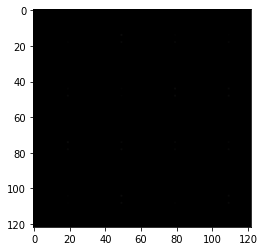

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


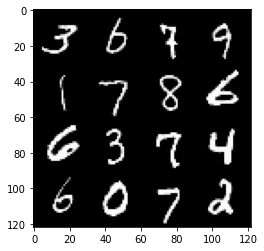

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2000: Generator loss: 3.0110579667761925, discriminator loss: 0.20695799015928096


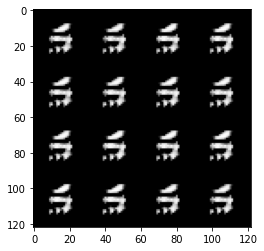

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


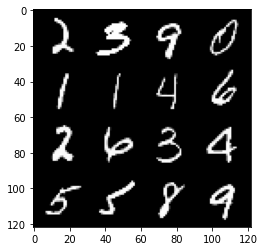

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3000: Generator loss: 1.6581853675991298, discriminator loss: 0.4741024295091629


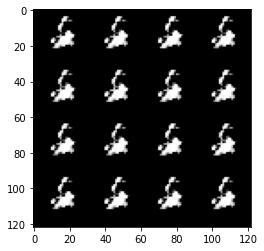

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


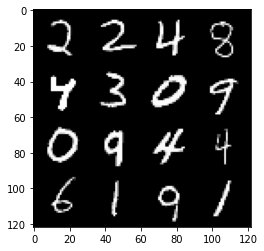

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 4000: Generator loss: 1.6321269443929192, discriminator loss: 0.4595644374191762


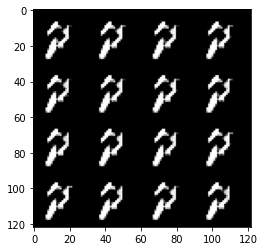

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


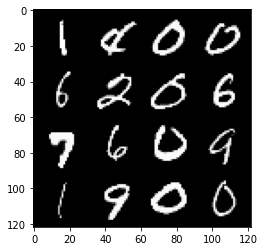

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 5000: Generator loss: 1.7557971210330743, discriminator loss: 0.4242731757164005


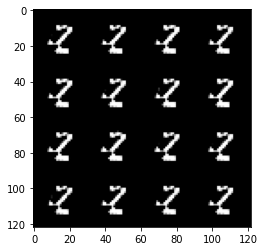

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


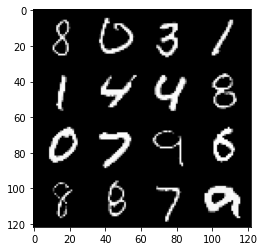

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 6000: Generator loss: 1.7709497716277822, discriminator loss: 0.4121359952837229


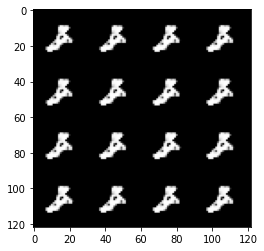

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


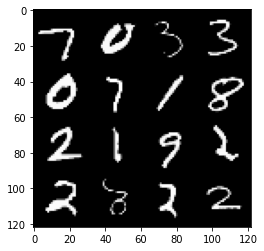

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 7000: Generator loss: 1.8099107245728365, discriminator loss: 0.43681751183420414


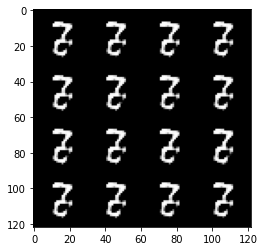

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


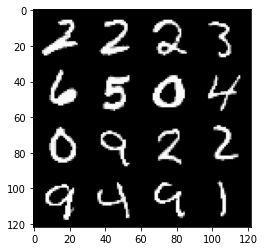

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 8000: Generator loss: 1.8379969131350502, discriminator loss: 0.4142257531993093


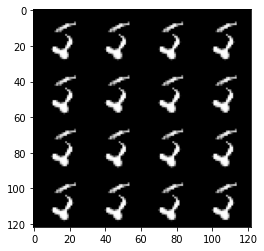

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


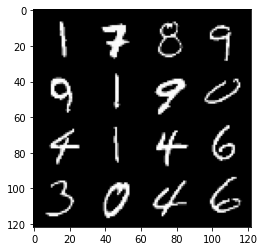

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 9000: Generator loss: 2.076609006702897, discriminator loss: 0.3347930982783437


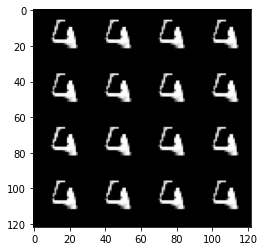

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


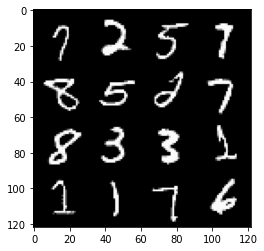

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 10000: Generator loss: 2.139167078256607, discriminator loss: 0.3282556471228601


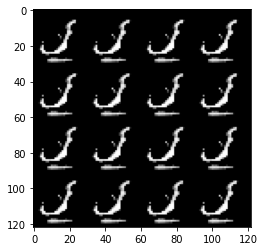

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


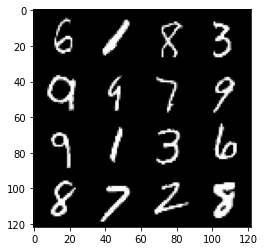

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 11000: Generator loss: 2.370763807579872, discriminator loss: 0.28518351250514384


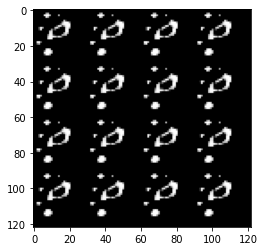

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


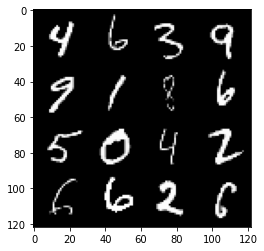

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 12000: Generator loss: 2.50020353038795, discriminator loss: 0.2863298699241133


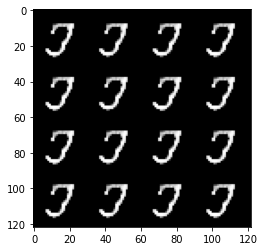

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


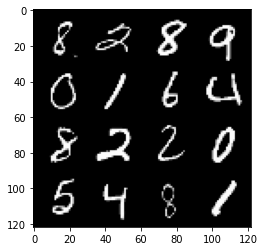

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 13000: Generator loss: 2.4320461352318525, discriminator loss: 0.2871068357303734


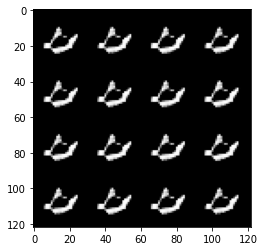

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


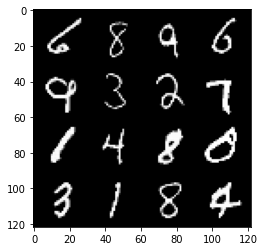

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 14000: Generator loss: 2.5680774428397446, discriminator loss: 0.27818465969339035


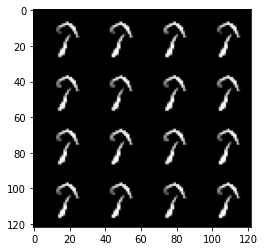

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


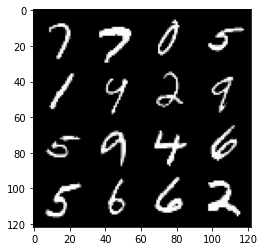

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 15000: Generator loss: 2.5260740666054216, discriminator loss: 0.2739687055870888


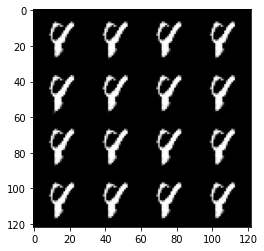

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


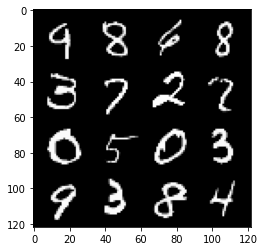

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 16000: Generator loss: 2.723741596430541, discriminator loss: 0.219643367625773


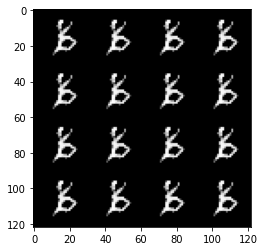

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


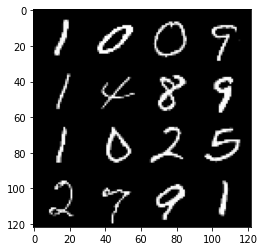

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 17000: Generator loss: 2.8221995424330224, discriminator loss: 0.23803483125194902


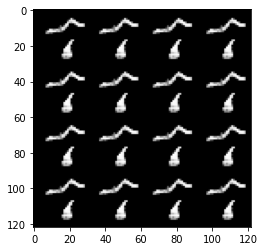

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


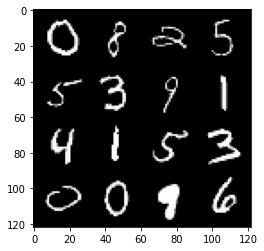

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 18000: Generator loss: 2.8839566323924806, discriminator loss: 0.21407673748396336


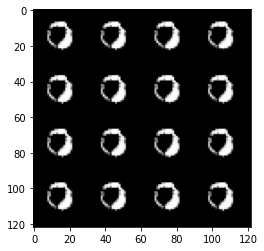

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


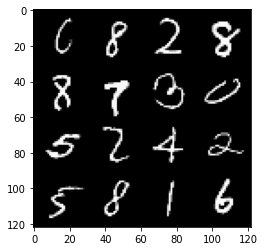

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 19000: Generator loss: 2.682295703643462, discriminator loss: 0.29144247579574595


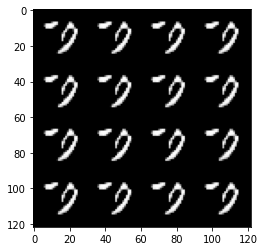

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


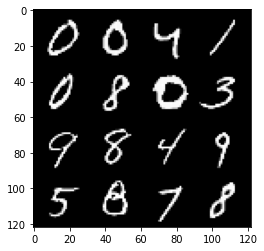

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 20000: Generator loss: 2.72463248697296, discriminator loss: 0.2299715142473577


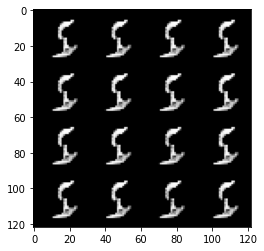

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


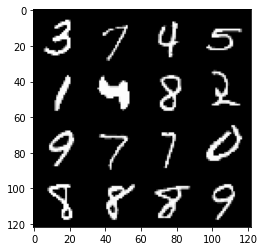

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 21000: Generator loss: 2.724769047707324, discriminator loss: 0.23611166162230093


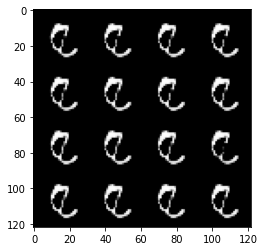

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


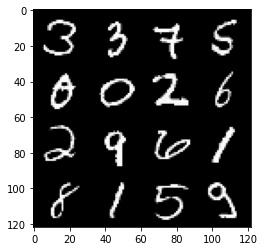

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 22000: Generator loss: 2.6344876032769697, discriminator loss: 0.2757147316141056


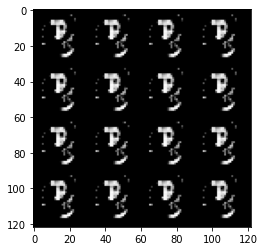

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


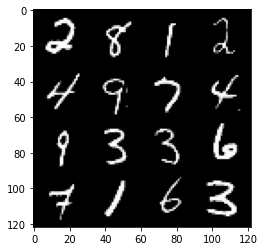

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 23000: Generator loss: 2.811920079959557, discriminator loss: 0.23297888854518517


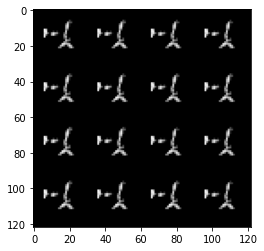

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


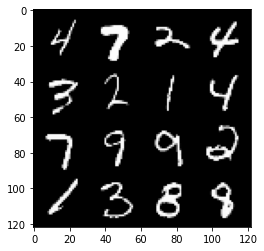

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 24000: Generator loss: 2.795729304566977, discriminator loss: 0.25225912019796615


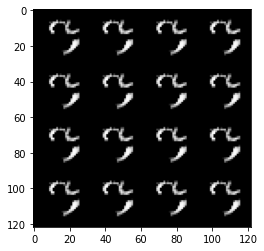

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


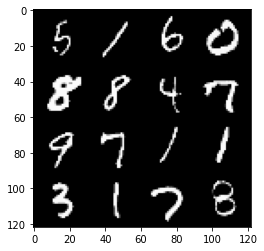

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 25000: Generator loss: 2.8719000450372696, discriminator loss: 0.214090245736763


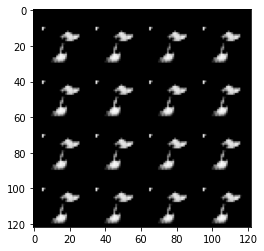

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


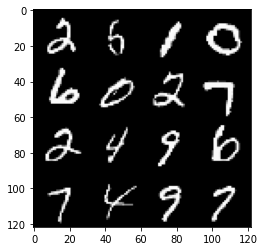

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 26000: Generator loss: 2.8490717721730476, discriminator loss: 0.2461246162727473


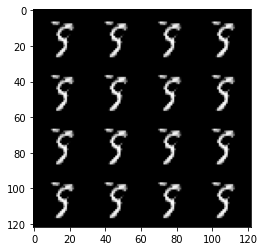

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


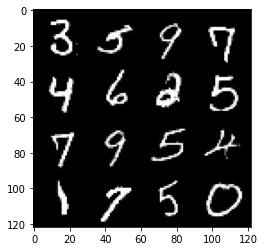

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 27000: Generator loss: 2.8844058563038706, discriminator loss: 0.23492580735869698


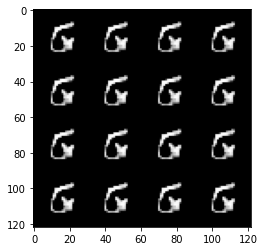

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


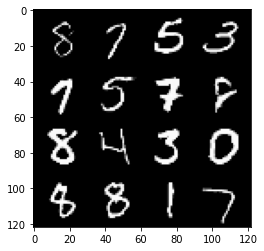

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 28000: Generator loss: 2.8284759940803075, discriminator loss: 0.22044305742345738


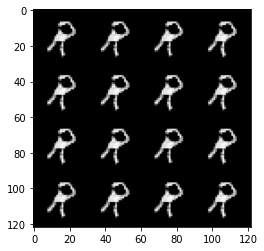

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


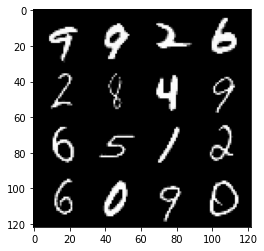

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 29000: Generator loss: 2.7463050014227632, discriminator loss: 0.2721867441385985


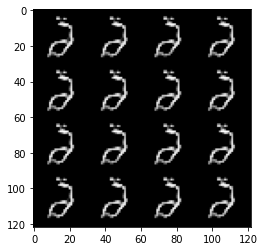

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


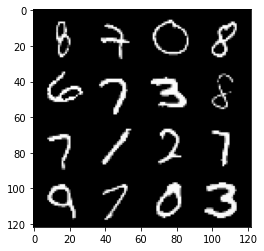

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 30000: Generator loss: 3.0041317760050283, discriminator loss: 0.17140836697071793


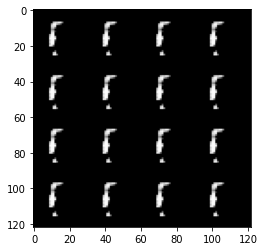

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


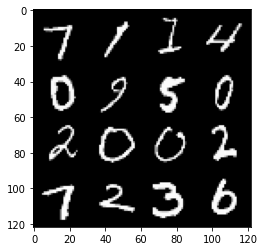

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 31000: Generator loss: 2.911874247372153, discriminator loss: 0.21952726679015977


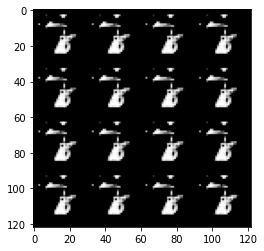

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


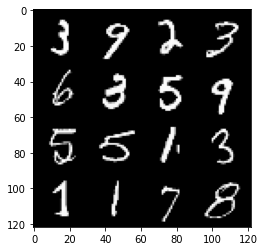

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 32000: Generator loss: 2.9029669534862, discriminator loss: 0.253200266893953


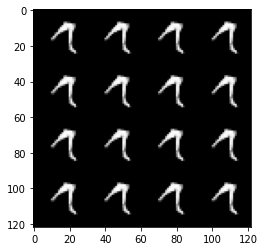

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


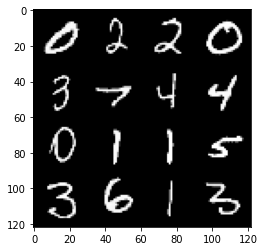

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 33000: Generator loss: 2.7671806825138603, discriminator loss: 0.23415653453022264


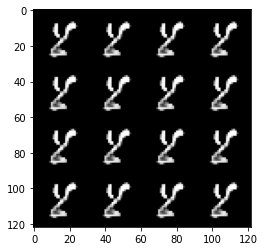

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


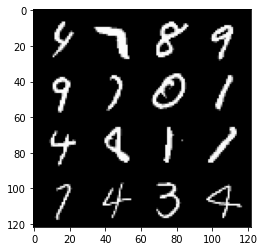

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 34000: Generator loss: 3.239354043312375, discriminator loss: 0.1687614588150754


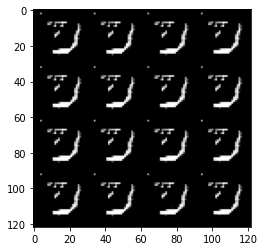

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


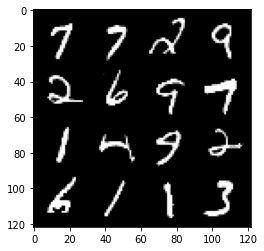

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 35000: Generator loss: 2.9829411819502716, discriminator loss: 0.2204729257626459


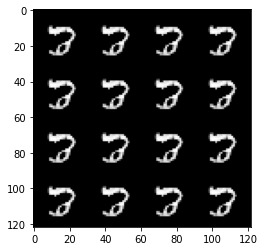

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


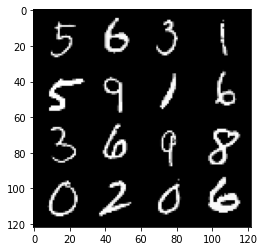

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 36000: Generator loss: 3.2836558896899217, discriminator loss: 0.1654207252738996


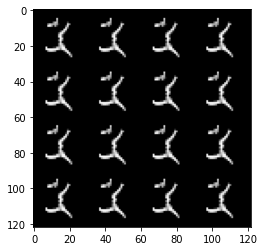

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


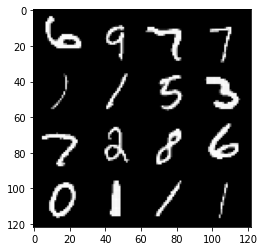

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 37000: Generator loss: 3.4164696743339293, discriminator loss: 0.22694016675325124


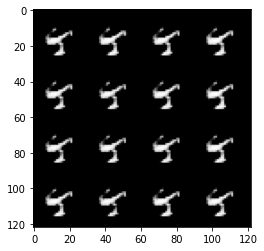

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


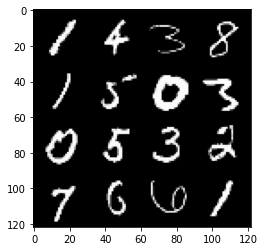

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 38000: Generator loss: 3.051045879140494, discriminator loss: 0.19003486522100854


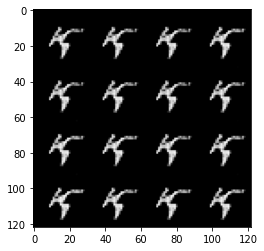

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


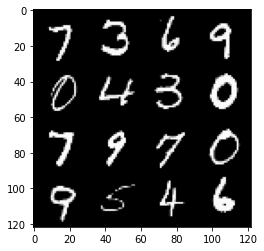

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 39000: Generator loss: 3.0439928396940203, discriminator loss: 0.24269825297594064


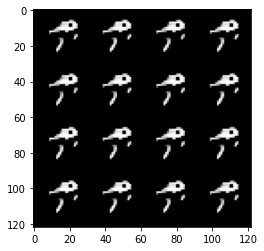

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


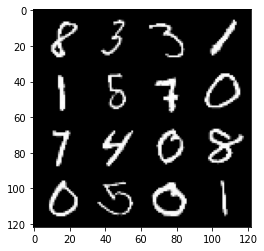

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 40000: Generator loss: 3.292475640214982, discriminator loss: 0.15200504738604634


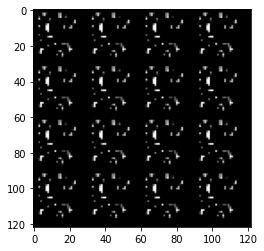

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


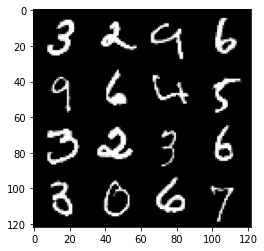

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 41000: Generator loss: 3.2631763230115207, discriminator loss: 0.15963776665413731


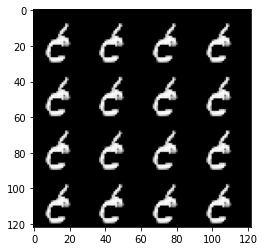

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


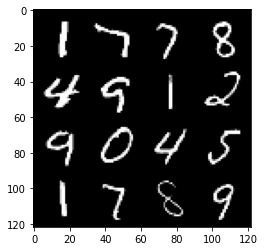

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 42000: Generator loss: 3.024775194957852, discriminator loss: 0.21220080193318422


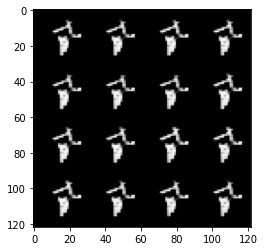

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


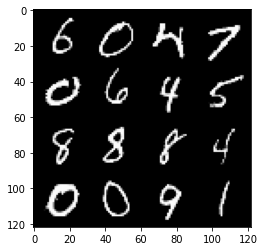

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 43000: Generator loss: 3.0760886613260925, discriminator loss: 0.2257013775333759


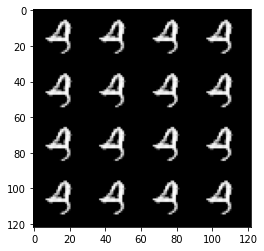

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


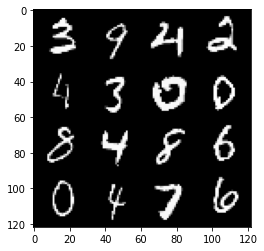

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 44000: Generator loss: 2.8704786768555595, discriminator loss: 0.20906634617224343


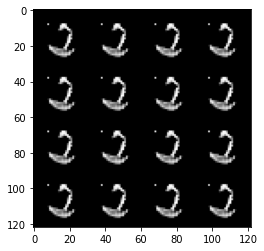

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


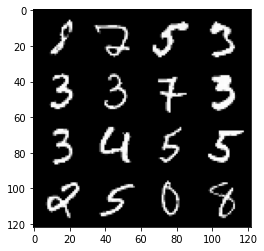

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 45000: Generator loss: 3.3959393728375415, discriminator loss: 0.14028547378350045


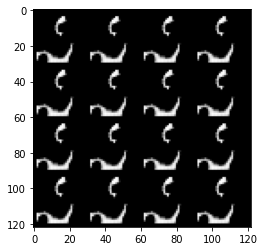

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


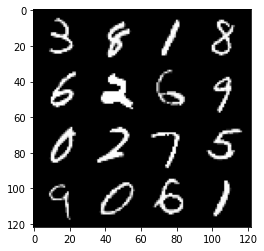

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 46000: Generator loss: 3.659371924787754, discriminator loss: 0.11616137799969863


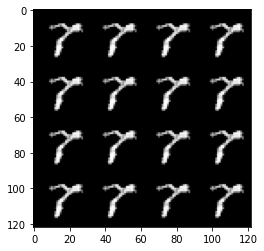

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


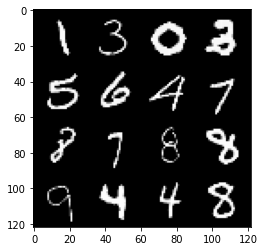

In [9]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0


for epoch in range(n_epochs):

    # Dataloader returns the batches
    for real, label in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update discriminator ##
        disc_opt.zero_grad()
        fake_noise = gen.get_noise(cur_batch_size, device=device)
        fake = gen(fake_noise)

        # # for fake images
        # detaching generator because we have to update only discriminator weights
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))

        # for real images
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))

        # mean discriminator loss
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = gen.get_noise(cur_batch_size, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1